In [1]:
import datetime
from nsepy import get_history
import pandas as pd
import sys
from datetime import date
import datetime
from fbprophet import Prophet
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
import warnings
import seaborn as sns
import yfinance as yf
import mpl_finance
import streamlit as st

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
warnings.warn("deprecated", DeprecationWarning)
%matplotlib inline

import pickle

/Users/vaigupta/Documents/Notebooks/anaconda3/lib/python3.7/site-packages/mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)
/Users/vaigupta/Documents/Notebooks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: deprecated


In [2]:
def refresh_data(equity,period1,interval1):
    equity1 = yf.Ticker(equity)
    history = equity1.history(period=period1,interval=interval1,actions=False)   
    return history

In [12]:
pd.read_csv('https://preferred.kotaksecurities.com/security/production/TradeApiInstruments_Cash_18_07_2022.txt',delimiter = '|')

,instrumentToken,instrumentName,name,lastPrice,expiry,strike,tickSize,lotSize,instrumentType,segment,exchange,isin,multiplier,exchangeToken,OptionType
0,9516,20MICRONS,20 Microns Ltd,71.95,0,0,0.05,1,EQ,CASH,NSE,INE144J01027,1,16921,-
1,43865,3IINFOLTD,3i Infotech Ltd,42.55,0,0,0.05,1,EQ,CASH,NSE,INE748C01038,1,6232,-
2,891,3MINDIA,3M India Ltd,21928.35,0,0,0.05,1,EQ,CASH,NSE,INE470A01017,1,474,-
3,607,3PLAND,3P Land Holdings Ltd,15.35,0,0,0.05,1,EQ,CASH,NSE,INE105C01023,1,2595,-
4,13140,5PAISA,5Paisa Capital Ltd,283.75,0,0,0.05,1,EQ,CASH,NSE,INE618L01018,1,445,-
5,5653,63MOONS,63 Moons Technologies Ltd,186.40,0,0,0.05,1,EQ,CASH,NSE,INE111B01023,1,11868,-
6,10586,A2ZINFRA,A2Z Infra Engineering Ltd,11.50,0,0,0.05,1,EQ,CASH,NSE,INE619I01012,1,20906,-
7,94320,AAKASH,Aakash Exploration Services Ltd,14.15,0,0,0.05,1,EQ,CASH,NSE,INE087Z01024,1,235,-
8,16680,AREYDRG,Aarey Drugs & Pharmaceuticals Ltd,35.05,0,0,0.05,1,EQ,CASH,NSE,INE198H01019,1,5245,-
9,15947,AARON,Aaron Industries Ltd,126.20,0,0,0.05,1,EQ,CASH,NSE,INE721Z01010,1,1030,-


### data extract above ##

In [144]:
def train_fn(data_tf,lookback_period,epochs,l_event):
  #converting dataset into x_train and y_train
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_tf[['Close']])  
    
    x, y = [], []
    for i in range(lookback_period,len(data_tf)):
        x.append(scaled_data[i-lookback_period:i,0])
        y.append(scaled_data[i,0])
     
    x = pd.DataFrame(x)
    y = pd.DataFrame(y)

    train = round(len(x)*0.90) 
    val =  round(len(x)*0.90) 
    test =  round(len(x))
    

    x_train,y_train = x[:train],y[:train]
    x_val,y_val = x[train:val],y[train:val]
    x_test,y_test = x[val:test],y[val:test]
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50,activation = 'relu'))
    model.add(Dense(1))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae','mape'])
    model_history  = model.fit(x_train, y_train, epochs=epochs, batch_size=5, verbose=1,validation_data=[x_val,y_val] )
    
    
    ## test metrics
    predictions = model.predict(x_test)
    test_predictions = scaler.inverse_transform(predictions)
    test_close_price = scaler.inverse_transform(y_test)
    
    mae=mean_absolute_error(test_predictions[l_event:],test_close_price[l_event:])
    mape = np. mean(np. abs((test_close_price[l_event:] - test_predictions[l_event:]) / test_close_price[l_event:])) * 100
    
    return model_history, model,mae,mape,x_test,y_test,scaler

In [145]:
model_history_5, model_5,mae_5,mape_5,x_test,y_test,scaler = train_fn(data_tf_5m,lookback_period=90,epochs=50,l_event=-100)
#model_history_15, model_15,mae_15,mape_15,x_test,y_test,scaler = train_fn(data_tf_15m,lookback_period=60,epochs=50,l_event=-10)


Epoch 1/50
793/793 [==============================] - 31s 36ms/step - loss: 0.0028 - mae: 0.0229 - mape: 13130.3652
Epoch 2/50
793/793 [==============================] - 31s 39ms/step - loss: 4.9026e-04 - mae: 0.0158 - mape: 10979.6758
Epoch 3/50
793/793 [==============================] - 32s 40ms/step - loss: 3.9132e-04 - mae: 0.0139 - mape: 12622.1172
Epoch 4/50
793/793 [==============================] - 32s 40ms/step - loss: 3.1602e-04 - mae: 0.0124 - mape: 10769.0322
Epoch 5/50
793/793 [==============================] - 31s 40ms/step - loss: 2.3944e-04 - mae: 0.0105 - mape: 12036.8154
Epoch 6/50
793/793 [==============================] - 32s 41ms/step - loss: 2.3595e-04 - mae: 0.0107 - mape: 8963.7354
Epoch 7/50
793/793 [==============================] - 279s 353ms/step - loss: 1.9036e-04 - mae: 0.0095 - mape: 10519.5957
Epoch 8/50
793/793 [==============================] - 2225s 3s/step - loss: 1.8068e-04 - mae: 0.0092 - mape: 6436.1826
Epoch 9/50
793/793 [========================

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
model_history_1h, model_1h,mae_1h,mape_1h,x_test_1h,y_test_1h,scaler_1h = train_fn(data_tf_1h,lookback_period=30,epochs=50,l_event=-10)

Epoch 1/50
747/747 [==============================] - 15s 16ms/step - loss: 0.0029 - mae: 0.0209 - mape: 4599.1147
Epoch 2/50
747/747 [==============================] - 9s 13ms/step - loss: 4.6589e-04 - mae: 0.0132 - mape: 4424.1157
Epoch 3/50
747/747 [==============================] - 10s 14ms/step - loss: 2.7269e-04 - mae: 0.0101 - mape: 5486.2578
Epoch 4/50
747/747 [==============================] - 9s 13ms/step - loss: 2.3082e-04 - mae: 0.0094 - mape: 5332.1108
Epoch 5/50
747/747 [==============================] - 10s 13ms/step - loss: 1.7075e-04 - mae: 0.0083 - mape: 3415.4209
Epoch 6/50
747/747 [==============================] - 11s 15ms/step - loss: 1.6228e-04 - mae: 0.0081 - mape: 4559.5776
Epoch 7/50
747/747 [==============================] - 12s 16ms/step - loss: 1.7151e-04 - mae: 0.0081 - mape: 4871.0977
Epoch 8/50
747/747 [==============================] - 13s 17ms/step - loss: 1.1458e-04 - mae: 0.0067 - mape: 8467.1436
Epoch 9/50
747/747 [==============================] - 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [146]:
mae_5

0.34316833496093724

### backtesting results

In [127]:
lookback_period = 90
scaled_data = scaler_1h.fit_transform(data_tf_5m[['Close']])

In [137]:
prediction_out = []
for x in range(len(scaled_data)-400,len(scaled_data)):
    prediction_value = model_5.predict(np.reshape(scaled_data[x-lookback_period:x,0],(1,-1)))
    prediction_out.append((x,scaler.inverse_transform(prediction_value)[0][0]))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [138]:
x_future = pd.DataFrame(prediction_out,columns = ['index','pred']).set_index(['index'])
#data_tf_15m.reset_index().merge(x_future, right_index=True,left_index=True)

In [139]:
x_future=data_tf_5m.reset_index().merge(x_future, right_index=True,left_index=True)

In [141]:
x_future.to_clipboard()

In [143]:
mae_5

0.4796279907226534

## Stratergy Builder

In [14]:
for i in range(2,df.shape[0]):
    
    current = df.iloc[i,:]
    prev = df.iloc[i-1,:]
    prev_2 = df.iloc[i-2,:]
    realbody = abs(current['Open'] - current['Close'])
    candle_range = current['High'] - current['Low']
    idx = df.index[i]

    # Bullish swing
    df.loc[idx,'Bullish swing'] = current['Low'] > prev['Low'] and prev['Low'] < prev_2['Low']
    # Bearish swing
    df.loc[idx,'Bearish swing'] = current['High'] < prev['High'] and prev['High'] > prev_2['High']
    # Bullish pinbar
    df.loc[idx,'Bullish pinbar'] = realbody <= candle_range/3 and  min(current['Open'], current['Close']) > (current['High'] + current['Low'])/2 and current['Low'] < prev['Low']
    # Bearish pinbar
    df.loc[idx,'Bearish pinbar'] = realbody <= candle_range/3 and max(current['Open'] , current['Close']) < (current['High'] + current['Low'])/2 and current['High'] > prev['High']

    # Inside bar
    df.loc[idx,'Inside bar'] = current['High'] < prev['High'] and current['Low'] > prev['Low']

    # Outside bar
    df.loc[idx,'Outside bar'] = if current['High'] > prev['High'] and current['Low'] < prev['Low']:
        df['Outside bar'] == "Buy"

    # Bullish engulfing
    df.loc[idx,'Bullish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] > current['Open']
    # Bearish engulfing
    df.loc[idx,'Bearish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] < current['Open']
    df.fillna(False, inplace=True)

SyntaxError: invalid syntax (<ipython-input-14-cf47dcf1497e>, line 23)

In [21]:
df = data_tf_5m
for i in range(2,df.shape[0]):
    
    current = df.iloc[i,:]
    prev = df.iloc[i-1,:]
    prev_2 = df.iloc[i-2,:]
    realbody = abs(current['Open'] - current['Close'])
    candle_range = current['High'] - current['Low']
    idx = df.index[i]

    # Bullish swing
    if current['Low'] > prev['Low'] and prev['Low'] < prev_2['Low']:
        df.loc[idx,'Bullish swing'] =df.loc[idx,'Close']
    # Bearish swing
    if current['High'] < prev['High'] and prev['High'] > prev_2['High']:
        df.loc[idx,'Bearish swing'] = df.loc[idx,'Close']
    # Bullish pinbar
    if realbody <= candle_range/3 and  min(current['Open'], current['Close']) > (current['High'] + current['Low'])/2 and current['Low'] < prev['Low']:
        df.loc[idx,'Bullish pinbar'] = df.loc[idx,'Close']
    # Bearish pinbar
    if realbody <= candle_range/3 and max(current['Open'] , current['Close']) < (current['High'] + current['Low'])/2 and current['High'] > prev['High']:
        df.loc[idx,'Bearish pinbar'] = df.loc[idx,'Close']

    # Inside bar
    if current['High'] < prev['High'] and current['Low'] > prev['Low']:
        df.loc[idx,'Inside bar']=df.loc[idx,'Close']
    # Outside bar
    if current['High'] > prev['High'] and current['Low'] < prev['Low']:
        df.loc[idx,'Outside bar'] = df.loc[idx,'Close']

    # Bullish engulfing
    if current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] > current['Open']:
        df.loc[idx,'Bullish engulfing']= df.loc[idx,'Close']
    # Bearish engulfing
    if current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] < current['Open']:
        df.loc[idx,'Bearish engulfing']=df.loc[idx,'Close']
    #df.fillna(False, inplace=True)

In [54]:
df = data_tf_5m
for i in range(5,df.shape[0]):
    
    current = df.iloc[i,:]
    prev = df.iloc[i-1,:]
    prev_2 = df.iloc[i-2,:]
    prev_3 = df.iloc[i-3,:]
    prev_4 = df.iloc[i-4,:]
    prev_5 = df.iloc[i-5,:]
    realbody = abs(current['Open'] - current['Close'])
    realbody_prev = abs(prev['Open'] - prev['Close'])
    upper_stick = abs(current['High'] - current['Close'])
    lower_stick = abs(current['Open'] - current['Low'])
    candle_range = current['High'] - current['Low']
    candle_range_prev = prev['High'] - prev['Low']
    idx = df.index[i]

    # Bullish swing
    if   realbody >= candle_range*0.80 and prev['Low']>prev_2['Low'] and prev_2['Low']>prev_3['Low'] and current['Close']>current['Open']:
        df.loc[idx,'V-Bullish swing'] =df.loc[idx,'Close']
    elif realbody >= candle_range*0.80 and prev['Low']<prev_2['Low'] and prev_2['Low']<prev_3['Low'] and current['Close']<current['Open']:
        df.loc[idx,'V-Bearish swing'] =df.loc[idx,'Close']
    elif upper_stick >= realbody*2 and current['Close'] == current['High'] and realbody_prev >= candle_range_prev*0.50 and current['High']>prev['High'] and current['Low']>prev['Low'] and prev['Low']>prev_2['Low'] and prev['High']>prev_2['High'] and prev_2['Low']>prev_3['Low'] and current['Close']>current['Open']:    
        df.loc[idx,'V-Trend Reversal'] =df.loc[idx,'Close']
    elif prev['Open']>prev_2['Open'] and prev_2['Open']>prev_3['Open'] and current['Close'] < current['Open'] and current['Open']>prev['Close'] and current['Open']>prev['Close']  and current['Close']<prev_2['Open'] and realbody > (realbody_prev*5) :
        df.loc[idx,'V-test swing'] =df.loc[idx,'Close']   

        

In [514]:
start_time = datetime.datetime.now()
historical_consolidated = pd.DataFrame(columns=['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'equity'])
for x in stocks:
    historical = refresh_data(x+'.NS','2D','1m').reset_index()
    historical['equity']=x
    historical_consolidated = historical_consolidated.append(historical,ignore_index=True)
historical_consolidated['Datetime'] = pd.to_datetime(historical_consolidated['Datetime'])
historical_consolidated['hour']=historical_consolidated['Datetime'].dt.hour
historical_consolidated['min']= historical_consolidated['Datetime'].dt.minute
historical_consolidated['day']= historical_consolidated['Datetime'].dt.day
df = historical_consolidated[historical_consolidated['day']!=1]

for i in range(5,df.shape[0]):
    
    current = df.iloc[i,:]
    prev = df.iloc[i-1,:]
    prev_2 = df.iloc[i-2,:]
    prev_3 = df.iloc[i-3,:]
    prev_4 = df.iloc[i-4,:]
    prev_5 = df.iloc[i-5,:]
    realbody = abs(current['Open'] - current['Close'])
    realbody_prev = abs(prev['Open'] - prev['Close'])
    realbody_prev2 = abs(prev_2['Open'] - prev_2['Close'])
    upper_stick = abs(current['High'] - current['Close'])
    lower_stick = abs(current['Open'] - current['Low'])
    candle_range = current['High'] - current['Low']
    candle_range_prev = prev['High'] - prev['Low']
    idx = df.index[i]

    #Bearish swing
    if prev['Close']>prev_2['Close'] and realbody_prev>prev['Close']*0.005 and realbody_prev2>prev['Close']*0.005  and prev_2['Close']>prev_3['Close'] and prev_2['Close']>prev_3['Close'] and prev['Close']>prev['Open'] and prev_2['Close']>prev_2['Open'] and current['Open'] > current['Close'] and current['Close'] < prev_2['Open'] and current['Open']>prev['Close']:
        df.loc[idx,'Bearish_Engulfing'] =df.loc[idx,'Close'] 
    ##bearish swing
    if prev['Close']<prev_2['Close'] and realbody >= candle_range*0.80 and realbody_prev>prev['Close']*0.005 and realbody_prev2>prev['Close']*0.005  and prev_2['Close']<prev_3['Close'] and prev_2['Close']<prev_3['Close'] and prev['Close']<prev['Open'] and prev_2['Close']<prev_2['Open'] and current['Open'] < current['Close'] and current['Close'] > prev_2['Open'] and current['Open']>prev['Close']:
        df.loc[idx,'Bullish_Engulfing'] =df.loc[idx,'Close']   
end_time =datetime.datetime.now()          

print('time taken to process complete task : {}'.format(end_time-start_time))



KeyboardInterrupt: 

In [460]:
start_time = datetime.datetime.now()
historical_consolidated = pd.DataFrame(columns=['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'equity'])
for x in stocks:
    historical = refresh_data(x+'.NS','1D','1m').reset_index()
    historical['equity']=x
    historical_consolidated = historical_consolidated.append(historical,ignore_index=True)
historical_consolidated['Datetime'] = pd.to_datetime(historical_consolidated['Datetime'])
historical_consolidated['hour']=historical_consolidated['Datetime'].dt.hour
historical_consolidated['min']= historical_consolidated['Datetime'].dt.minute

In [369]:
eq_min_max= historical_consolidated[(historical_consolidated['hour']==9) & (historical_consolidated['min']<20) ].groupby(['equity']).agg({'Open':['min'],'Close':['max']})
day_min_max= historical_consolidated.groupby(['equity']).agg({'Open':['min'],'Close':['max']})
eq_min_max.columns=['Low_pp','High_pp']
day_min_max.columns=['day_Low','day_High']
historical_consolidated = historical_consolidated.merge(eq_min_max,on='equity')
historical_consolidated = historical_consolidated.merge(day_min_max,on='equity')


In [8]:
start_time = datetime.datetime.now()
historical_consolidated = pd.DataFrame(columns=['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'equity'])

for x in stocks:
    historical = refresh_data(x+'.NS','1D','5m').reset_index()
    historical['equity']=x
    historical_consolidated = historical_consolidated.append(historical,ignore_index=True)
    
historical_consolidated.drop(columns =['Volume'],inplace=True)    
historical_consolidated['Datetime'] = pd.to_datetime(historical_consolidated['Datetime']).dt.tz_localize(None)
historical_consolidated['hour']=historical_consolidated['Datetime'].dt.hour
historical_consolidated['min']= historical_consolidated['Datetime'].dt.minute
historical_consolidated['day']= historical_consolidated['Datetime'].dt.day

historical_consolidated['Open_Max']= historical_consolidated[['Open','Close']].max(axis=1)
historical_consolidated['Open_Min']= historical_consolidated[['Open','Close']].min(axis=1)

eq_min_max= historical_consolidated[(historical_consolidated['hour']==9) & (historical_consolidated['min']<35)].groupby(['equity']).agg({'Open_Min':['min'],'Open_Max':['max']})
day_min_max= historical_consolidated.groupby(['equity']).agg({'Open':['min'],'Close':['max']})
eq_min_max.columns=['Low_pp','High_pp']
day_min_max.columns=['day_Low','day_High']
historical_consolidated = historical_consolidated.merge(eq_min_max,on='equity')
historical_consolidated = historical_consolidated.merge(day_min_max,on='equity')

df = historical_consolidated[(historical_consolidated['hour']>10) & (historical_consolidated['hour']<15)]
df['bb']=0
df['day_breakout']=0
df['day_breakdown']=0

for i in range(5,df.shape[0]): 
    current = df.iloc[i,:]
    prev = df.iloc[i-1,:]
    prev_2 = df.iloc[i-2,:]
    prev_3 = df.iloc[i-3,:]
    prev_4 = df.iloc[i-4,:]
    prev_5 = df.iloc[i-5,:]
    realbody = abs(current['Open'] - current['Close'])
    realbody_prev = abs(prev['Open'] - prev['Close'])
    realbody_prev2 = abs(prev_2['Open'] - prev_2['Close'])
    upper_stick = abs( current['High'] - current['Close'])
    lower_stick = abs(current['Open'] - current['Low'])
    candle_range = current['High'] - current['Low']
    candle_range_prev = abs(prev['High'] - prev['Low'])
    idx = df.index[i]

    if prev['Open']<prev['High_pp'] and prev['Close']>prev['High_pp'] and current['Open']>prev['Close'] and current['Close']>current['Open']  and current['bb']==0 and prev['Open'] < prev['Close'] and realbody_prev > candle_range_prev *0.80:
        df.loc[idx,'day_breakout'] =df.loc[idx,'Close']
        df.loc[df['equity']==current['equity'],'bb']=1
        
    elif prev['Open']>=prev['Low_pp'] and prev['Low_pp']>prev['Close'] and current['Open']<prev['Close'] and prev['Open']>prev['Close'] and current['Close']<current['Open'] and current['bb']==0 and realbody_prev > candle_range_prev *0.80:
        df.loc[idx,'day_breakdown'] =df.loc[idx,'Close']
        df.loc[df['equity']==current['equity'],'bb']=1
        
end_time =datetime.datetime.now()          

print('time taken to process complete task : {}'.format(end_time-start_time)) 


/Users/vaigupta/Documents/Notebooks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vaigupta/Documents/Notebooks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vaigupta/Documents/Notebooks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

time taken to process complete task : 0:02:59.691535


In [9]:
test= df[(df['day_breakout']>0) | (df['day_breakdown']>0)]
test['delta_up'] = ((test['day_High']-test['day_breakout'])/test['day_High'])*100
test['delta_down'] = ((test['day_breakdown']-test['day_Low'])/test['day_breakdown'])*100
test

/Users/vaigupta/Documents/Notebooks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vaigupta/Documents/Notebooks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Datetime,Open,High,Low,Close,equity,hour,min,day,Open_Max,Open_Min,Low_pp,High_pp,day_Low,day_High,bb,day_breakout,day_breakdown,delta_up,delta_down
2131,2022-07-15 11:45:00,370.149994,370.549988,370.100006,370.549988,AMBUJACEM,11,45,15,370.549988,370.149994,368.450012,369.799988,368.450012,371.100006,1,370.549988,0.000000,0.148213,-inf
2350,2022-07-15 11:05:00,3890.050049,3891.199951,3882.850098,3888.449951,APOLLOHOSP,11,5,15,3890.050049,3888.449951,3898.100098,3941.949951,3885.350098,3941.649902,1,0.000000,3888.449951,100.000000,0.079720
2991,2022-07-15 14:55:00,1775.300049,1782.099976,1775.150024,1780.199951,ASTRAL,14,55,15,1780.199951,1775.300049,1767.550049,1773.150024,1761.849976,1790.949951,1,1780.199951,0.000000,0.600240,-inf
3242,2022-07-15 11:05:00,3894.050049,3897.949951,3894.000000,3894.000000,DMART,11,5,15,3894.050049,3894.000000,3897.000000,3930.000000,3891.000000,3937.850098,1,0.000000,3894.000000,100.000000,0.077042
4762,2022-07-15 12:50:00,240.649994,241.050003,240.500000,240.850006,BEL,12,50,15,240.850006,240.649994,237.850006,239.699997,237.850006,246.199997,1,240.850006,0.000000,2.173026,-inf
6727,2022-07-15 13:55:00,763.049988,767.400024,763.049988,765.000000,CARBORUNIV,13,55,15,765.000000,763.049988,758.200012,761.950012,748.250000,770.849976,1,765.000000,0.000000,0.758899,-inf
12722,2022-07-15 13:25:00,1328.449951,1329.949951,1328.300049,1329.349976,GODREJPROP,13,25,15,1329.349976,1328.449951,1320.099976,1327.949951,1320.099976,1346.949951,1,1329.349976,0.000000,1.306654,-inf
14514,2022-07-15 13:05:00,1246.000000,1246.300049,1245.000000,1245.800049,HAVELLS,13,5,15,1246.000000,1245.800049,1247.000000,1257.150024,1244.000000,1257.000000,1,0.000000,1245.800049,100.000000,0.144489
15129,2022-07-15 14:05:00,239.250000,239.350006,238.850006,239.350006,HINDPETRO,14,5,15,239.350006,239.250000,238.149994,239.000000,235.750000,241.350006,1,239.350006,0.000000,0.828672,-inf
17578,2022-07-15 14:15:00,1413.150024,1417.250000,1411.099976,1415.599976,INDIGOPNTS,14,15,15,1415.599976,1413.150024,1402.150024,1411.800049,1402.150024,1415.599976,1,1415.599976,0.000000,0.000000,-inf


In [10]:
df.loc[:,'day_breakout']=0

In [761]:
historical_consolidated['Datetime'].max()####################################################################################################################################

from ks_api_client import ks_api

client = ks_api.KSTradeApi(access_token = "b0f15099-04ff-3f2c-a737-7cf9fff489b2", userid = "VG27101991", consumer_key = "JSaisisrZVPlJAUtJfJfAKxCnOka",ip = "127.0.0.1", app_id = "", \
                        host = "https://tradeapi.kotaksecurities.com/apim", consumer_secret = "saDBHcrZ2aTIUMcOzgt_Z_WNc4wa")

client.login(password = "Rake@3427")
client.session_2fa()

try:
    # Get historical prices
    client.history("historicalprices",{"exchange":"NSE","cocode":"4481","fromdate":"01-jan-2020","todate":"08-oct-2020"})
except Exception as e:
    print("Exception when calling Historical API->details: %s\n" % e)                        


client.quote(instrument_token = 110)


client.history("historicalprices-unadjusted",{"exchange":"bse","co_code":"110","date":"16-Jun-2016"})

client.history("historicalprices",{"exchange":"NSE","cocode":"476","fromdate":"01-jan-2020","todate":"08-oct-2020"})

client.history("historicalprices",{})

token = []
name= []
3320 * 0.995

order_info = [
            {"instrument_token": 4106, "quantity": , "price": 3320, "amount": 30000, "trigger_price": 3320}
        ]
ss = client.margin_required(transaction_type="BUY",order_info=order_info)

ss.get('Success')[0].get('normal')

for x in range(100,103):
        token.append(x)
        name.append(client.quote(instrument_token = 8210).get('success')[0].get('stk_name'))            

Timestamp('2022-07-04 10:46:23')

In [588]:
if (end_time - test.iloc[0,0]).total_seconds() < 300 :
    

396440.579551

In [6]:
stocks=[
    '3MINDIA',
'ABB',
'ACC',
'AIAENG',
'APLAPOLLO',
'AUBANK',
'AARTIDRUGS',
'AAVAS',
'ABBOTINDIA',
'ADANIENT',
'ADANIGREEN',
'ADANIPORTS',
'ATGL',
'ADANITRANS',
'ABCAPITAL',
'ABFRL',
'ABSLAMC',
'ADVENZYMES',
'AEGISCHEM',
'AFFLE',
'AJANTPHARM',
'APLLTD',
'ALKEM',
'ALKYLAMINE',
'ALLCARGO',
'ALOKINDS',
'AMARAJABAT',
'AMBER',
'AMBUJACEM',
'ANGELONE',
'ANURAS',
'APOLLOHOSP',
'APOLLOTYRE',
'APTUS',
'ASAHIINDIA',
'ASHOKLEY',
'ASIANPAINT',
'ASTERDM',
'ASTRAZEN',
'ASTRAL',
'ATUL',
'AUROPHARMA',
'AVANTIFEED',
'DMART',
'AXISBANK',
'BASF',
'BSE',
'BAJAJ-AUTO',
'BAJAJELEC',
'BAJFINANCE',
'BAJAJFINSV',
'BAJAJHLDNG',
'BALAMINES',
'BALKRISIND',
'BALRAMCHIN',
'BANDHANBNK',
'BANKBARODA',
'BANKINDIA',
'MAHABANK',
'BATAINDIA',
'BAYERCROP',
'BERGEPAINT',
'BDL',
'BEL',
'BHARATFORG',
'BHEL',
'BPCL',
'BHARTIARTL',
'BIOCON',
'BIRLACORPN',
'BSOFT',
'BLUEDART',
'BLUESTARCO',
'BBTC',
'BORORENEW',
'BOSCHLTD',
'BRIGADE',
'BCG',
'BRITANNIA',
'MAPMYINDIA',
'CCL',
'CESC',
'CGPOWER',
'CRISIL',
'CSBBANK',
'CANFINHOME',
'CANBK',
'CAPLIPOINT',
'CGCL',
'CARBORUNIV',
'CASTROLIND',
'CEATLTD',
'CENTRALBK',
'CDSL',
'CENTURYPLY',
'CENTURYTEX',
'CERA',
'CHALET',
'CHAMBLFERT',
'CHEMPLASTS',
'CHOLAHLDNG',
'CHOLAFIN',
'CIPLA',
'CUB',
'CLEAN',
'COALINDIA',
'COCHINSHIP',
'COFORGE',
'COLPAL',
'CAMS',
'CONCOR',
'COROMANDEL',
'CREDITACC',
'CROMPTON',
'CUMMINSIND',
'CYIENT',
'DCMSHRIRAM',
'DLF',
'DABUR',
'DALBHARAT',
'DEEPAKNTR',
'DELTACORP',
'DEVYANI',
'DHANI',
'DBL',
'DIVISLAB',
'DIXON',
'LALPATHLAB',
'DRREDDY',
'EIDPARRY',
'EIHOTEL',
'EPL',
'EASEMYTRIP',
'EDELWEISS',
'EICHERMOT',
'ELGIEQUIP',
'EMAMILTD',
'ENDURANCE',
'ENGINERSIN',
'EQUITAS',
'EQUITASBNK',
'ERIS',
'ESCORTS',
'EXIDEIND',
'FDC',
'NYKAA',
'FEDERALBNK',
'FACT',
'FINEORG',
'FINCABLES',
'FINPIPE',
'FSL',
'FORTIS',
'GRINFRA',
'GAIL',
'GMMPFAUDLR',
'GMRINFRA',
'GALAXYSURF',
'GARFIBRES',
'GICRE',
'GLAND',
'GLAXO',
'GLS',
'GLENMARK',
'GOCOLORS',
'GODFRYPHLP',
'GODREJAGRO',
'GODREJCP',
'GODREJIND',
'GODREJPROP',
'GRANULES',
'GRAPHITE',
'GRASIM',
'GESHIP',
'GRINDWELL',
'GUJALKALI',
'GAEL',
'FLUOROCHEM',
'GUJGASLTD',
'GNFC',
'GPPL',
'GSFC',
'GSPL',
'HEG',
'HCLTECH',
'HDFCAMC',
'HDFCBANK',
'HDFCLIFE',
'HFCL',
'HLEGLAS',
'HAPPSTMNDS',
'HATHWAY',
'HATSUN',
'HAVELLS',
'HEMIPROP',
'HEROMOTOCO',
'HIKAL',
'HINDALCO',
'HGS',
'HAL',
'HINDCOPPER',
'HINDPETRO',
'HINDUNILVR',
'HINDZINC',
'POWERINDIA',
'HOMEFIRST',
'HONAUT',
'HUDCO',
'HDFC',
'ICICIBANK',
'ICICIGI',
'ICICIPRULI',
'ISEC',
'IDBI',
'IDFCFIRSTB',
'IDFC',
'IFBIND',
'IIFL',
'IIFLWAM',
'IRB',
'IRCON',
'ITC',
'ITI',
'INDIACEM',
'IBULHSGFIN',
'IBREALEST',
'INDIAMART',
'INDIANB',
'IEX',
'INDHOTEL',
'IOC',
'IOB',
'IRCTC',
'IRFC',
'INDIGOPNTS',
'ICIL',
'INDOCO',
'IGL',
'INDUSTOWER',
'INDUSINDBK',
'INFIBEAM',
'NAUKRI',
'INFY',
'INOXLEISUR',
'INTELLECT',
'INDIGO',
'IPCALAB',
'JBCHEPHARM',
'JKCEMENT',
'JKLAKSHMI',
'JKPAPER',
'JMFINANCIL',
'JSWENERGY',
'JSWSTEEL',
'JAMNAAUTO',
'JSL',
'JINDALSTEL',
'JUBLFOOD',
'JUBLINGREA',
'JUBLPHARMA',
'JUSTDIAL',
'JYOTHYLAB',
'KPRMILL',
'KEI',
'KNRCON',
'KPITTECH',
'KRBL',
'KAJARIACER',
'KALPATPOWR',
'KALYANKJIL',
'KANSAINER',
'KARURVYSYA',
'KEC',
'KOTAKBANK',
'KIMS',
'L&TFH',
'LTTS',
'LICHSGFIN',
'LAXMIMACH',
'LTI',
'LT',
'LATENTVIEW',
'LAURUSLABS',
'LXCHEM',
'LINDEINDIA',
'LUPIN',
'LUXIND',
'MMTC',
'MOIL',
'MRF',
'MTARTECH',
'LODHA',
'MGL',
'M&MFIN',
'M&M',
'MAHINDCIE',
'MHRIL',
'MAHLOG',
'MANAPPURAM',
'MRPL',
'MARICO',
'MARUTI',
'MASTEK',
'MFSL',
'MAXHEALTH',
'MAZDOCK',
'MEDPLUS',
'METROBRAND',
'METROPOLIS',
'MINDTREE',
'MINDAIND',
'MOTILALOFS',
'MPHASIS',
'MCX',
'MUTHOOTFIN',
'NATCOPHARM',
'NBCC',
'NCC',
'NESCO',
'NHPC',
'NLCINDIA',
'NMDC',
'NOCIL',
'NTPC',
'NH',
'NATIONALUM',
'NAVINFLUOR',
'NAZARA',
'NESTLEIND',
'NETWORK18',
'NAM-INDIA',
'NUVOCO',
'OBEROIRLTY',
'ONGC',
'OIL',
'PAYTM',
'OFSS',
'ORIENTELEC',
'POLICYBZR',
'PCBL',
'PIIND',
'PNBHOUSING',
'PNCINFRA',
'PVR',
'PAGEIND',
'PERSISTENT',
'PETRONET',
'PFIZER',
'PHOENIXLTD',
'PIDILITIND',
'PEL',
'POLYMED',
'POLYCAB',
'POLYPLEX',
'POONAWALLA',
'PFC',
'POWERGRID',
'PRAJIND',
'PRESTIGE',
'PRINCEPIPE',
'PRSMJOHNSN',
'PRIVISCL',
'PGHL',
'PGHH',
'PNB',
'QUESS',
'RBLBANK',
'RECLTD',
'RHIM',
'RITES',
'RADICO',
'RVNL',
'RAILTEL',
'RAIN',
'RAJESHEXPO',
'RALLIS',
'RCF',
'RATNAMANI',
'RTNINDIA',
'REDINGTON',
'RELAXO',
'RELIANCE',
'RBA',
'ROSSARI',
'ROUTE',
'SBICARD',
'SBILIFE',
'SIS',
'SJVN',
'SKFINDIA',
'SRF',
'SANOFI',
'SAPPHIRE',
'SAREGAMA',
'SCHAEFFLER',
'SEQUENT',
'SFL',
'SHILPAMED',
'SCI',
'SHREECEM',
'RENUKA',
'SHRIRAMCIT',
'SRTRANSFIN',
'SHYAMMETL',
'SIEMENS',
'SOBHA',
'SOLARINDS',
'SOLARA',
'SONACOMS',
'SONATSOFTW',
'SPICEJET',
'STARHEALTH',
'SBIN',
'SAIL',
'SWSOLAR',
'STLTECH',
'STAR',
'SUDARSCHEM',
'SUMICHEM',
'SPARC',
'SUNPHARMA',
'SUNTV',
'SUNDARMFIN',
'SUNDRMFAST',
'SUNTECK',
'SUPRAJIT',
'SUPREMEIND',
'SUVENPHAR',
'SUZLON',
'SYMPHONY',
'SYNGENE',
'TCIEXP',
'TCNSBRANDS',
'TTKPRESTIG',
'TV18BRDCST',
'TVSMOTOR',
'TANLA',
'TATACHEM',
'TATACOFFEE',
'TATACOMM',
'TCS',
'TATACONSUM',
'TATAELXSI',
'TATAINVEST',
'TATAMTRDVR',
'TATAMOTORS',
'TATAPOWER',
'TATASTLLP',
'TATASTEEL',
'TTML',
'TEAMLEASE',
'TECHM',
'NIACL',
'RAMCOCEM',
'THERMAX',
'THYROCARE',
'TIMKEN',
'TITAN',
'TORNTPHARM',
'TORNTPOWER',
'TRENT',
'TRIDENT',
'TRIVENI',
'TRITURBINE',
'TIINDIA',
'UCOBANK',
'UFLEX',
'UPL',
'UTIAMC',
'ULTRACEMCO',
'UNIONBANK',
'UBL',
'MCDOWELL-N',
'VGUARD',
'VMART',
'VIPIND',
'VAIBHAVGBL',
'VAKRANGEE',
'VTL',
'VARROC',
'VBL',
'VEDL',
'VENKEYS',
'VIJAYA',
'VINATIORGA',
'IDEA',
'VOLTAS',
'WELCORP',
'WELSPUNIND',
'WESTLIFE',
'WHIRLPOOL',
'WIPRO',
'WOCKPHARMA',
'YESBANK',
'ZFCVINDIA',
'ZEEL',
'ZENSARTECH',
'ZOMATO',
'ZYDUSLIFE',
'ZYDUSWELL',
'ECLERX'
]

In [ ]:
## prod code -- for testing

In [279]:
historical_consolidated.shape

(37521, 10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyError: 'V-Trend Reversal'

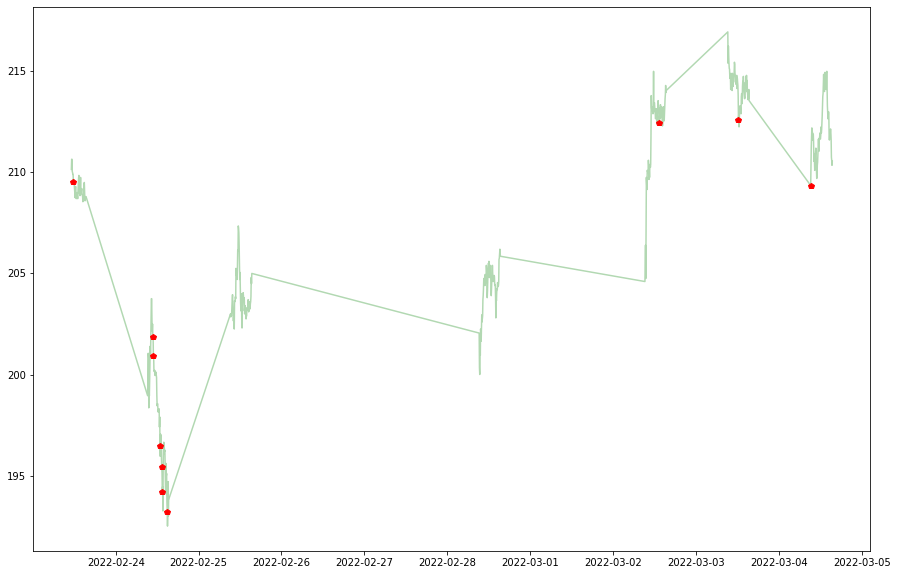

In [59]:
period  =500
df['EMA_10'] = df.Close.ewm(span=period).mean()
plt.figure(figsize=(15, 10))
#plt.plot(x_future['Datetime'],x_future[1], color="r", alpha=.8)
plt.plot(df.index[-period:],df['Close'][-period:], color="g", alpha=.3)
plt.plot(df.index[-period:],df['V-Bearish swing'][-period:],marker="p", color="r", alpha=1.0,label="Bullish Swing")
plt.plot(df.index[-period:],df['V-Trend Reversal'][-period:],marker="*", color="b", alpha=1.0,label="Bearish Swing")
plt.plot(df.index[-period:],df['EMA_10'][-period:])
plt.legend()
plt.show()

In [55]:
data_tf_5m.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2021-12-23 09:15:00+05:30,257.500000,258.899994,257.299988,257.549988,0,0.0,0
2021-12-23 09:20:00+05:30,257.600006,258.200012,256.899994,257.399994,547958,0.0,0
2021-12-23 09:25:00+05:30,257.549988,257.600006,256.700012,256.950012,325167,0.0,0
2021-12-23 09:30:00+05:30,257.100006,257.250000,256.000000,256.100006,362003,0.0,0
2021-12-23 09:35:00+05:30,256.000000,256.649994,255.550003,256.399994,391892,0.0,0


In [366]:
    if  int(realbody)>= int(candle_range)*0.90:
        df.loc[idx,'V-Bullish swing'] =df.loc[idx,'Close']
        print("Hello")

In [376]:
data_tf_15m.iloc[1470:1480]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2022-03-02 14:15:00+05:30,2388.050049,2389.500000,2378.199951,2382.949951,404158,0,0
2022-03-02 14:30:00+05:30,2383.050049,2397.350098,2383.050049,2396.100098,331576,0,0
2022-03-02 14:45:00+05:30,2396.100098,2397.000000,2389.500000,2392.500000,314237,0,0
2022-03-02 15:00:00+05:30,2393.000000,2400.000000,2391.550049,2395.199951,776312,0,0
2022-03-02 15:15:00+05:30,2395.699951,2400.000000,2395.000000,2395.250000,841380,0,0
2022-03-03 09:15:00+05:30,2400.149902,2414.800049,2400.149902,2404.899902,235196,0,0
2022-03-03 09:30:00+05:30,2405.250000,2406.050049,2394.000000,2395.800049,250210,0,0
2022-03-03 09:45:00+05:30,2395.850098,2403.800049,2393.000000,2396.850098,127938,0,0
2022-03-03 10:00:00+05:30,2396.850098,2399.899902,2391.600098,2399.000000,182835,0,0


In [344]:
realbody_prev >= candle_range_prev*0.90

False

In [354]:
if  realbody >= candle_range*0.90:
    print("Hello")

In [353]:
realbody

4.75

In [348]:
realbody >= candle_range*0.90

True

In [317]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'EMA_10'],
      dtype='object')

### Moving Average Crossover

In [75]:
df = data_tf_5m

In [79]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_09,SMA_18
Datetime,,,,,,,,,
2021-12-16 09:15:00+05:30,2400.000000,2402.649902,2385.000000,2385.850098,204653,0,0,2385.850098,2385.850098
2021-12-16 09:30:00+05:30,2385.850098,2388.149902,2380.000000,2385.699951,336046,0,0,2385.775024,2385.775024
2021-12-16 09:45:00+05:30,2385.500000,2387.000000,2371.100098,2377.100098,239156,0,0,2382.883382,2382.883382
2021-12-16 10:00:00+05:30,2377.100098,2379.000000,2371.050049,2378.000000,90114,0,0,2381.662537,2381.662537
2021-12-16 10:15:00+05:30,2378.000000,2381.500000,2376.000000,2380.100098,84891,0,0,2381.350049,2381.350049


In [78]:
df['SMA_09'] = df.Close.rolling(9, min_periods=1).mean()
df['SMA_18'] = df.Close.rolling(18, min_periods=1).mean()

In [80]:
for i in range(100,df.shape[0]):
    
    current = df.iloc[i,:]
    prev = df.iloc[i-1,:]
    prev_2 = df.iloc[i-2,:]
    prev_3 = df.iloc[i-3,:]
    prev_4 = df.iloc[i-4,:]
    prev_5 = df.iloc[i-5,:]
    idx = df.index[i]
    
    if current['SMA_09']>current['SMA_18'] and prev['SMA_09']<prev['SMA_18']:
        df.loc[idx,'MA_Crossover'] = df.loc[idx,'Close']

In [82]:
df[df['MA_Crossover']>0]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_09,SMA_18,MA_Crossover
Datetime,,,,,,,,,,
2021-12-22 10:30:00+05:30,2336.000000,2339.800049,2331.000000,2334.899902,180798,0,0,2335.577772,2333.388889,2334.899902
2021-12-22 13:45:00+05:30,2345.399902,2348.000000,2342.000000,2345.600098,127836,0,0,2342.011149,2341.172228,2345.600098
2021-12-24 13:00:00+05:30,2358.500000,2360.000000,2351.100098,2353.199951,67052,0,0,2354.861111,2354.175008,2353.199951
2021-12-27 12:15:00+05:30,2369.750000,2375.000000,2369.199951,2372.000000,72962,0,0,2368.105523,2367.702772,2372.000000
2021-12-29 14:45:00+05:30,2396.250000,2399.500000,2395.000000,2395.199951,136455,0,0,2394.088867,2392.749986,2395.199951
2021-12-31 11:00:00+05:30,2364.000000,2369.399902,2360.000000,2369.399902,147065,0,0,2369.905518,2368.605537,2369.399902
2022-01-05 13:00:00+05:30,2455.800049,2459.050049,2447.649902,2452.949951,251734,0,0,2444.511149,2444.444472,2452.949951
2022-01-06 14:30:00+05:30,2423.000000,2425.949951,2418.000000,2420.500000,243683,0,0,2421.161133,2420.019463,2420.500000
2022-01-10 10:00:00+05:30,2445.149902,2447.750000,2443.649902,2446.800049,72864,0,0,2434.144423,2432.480550,2446.800049


In [1]:
import pandas as pd

In [15]:
ss = pd.read_clipboard()

In [16]:
ss['EVENT_DATE'] = pd.to_datetime(ss['EVENT_DATE'])

In [17]:
ss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
CONTACT_ID          801 non-null object
GPID                799 non-null float64
EVENT_DATE          801 non-null datetime64[ns]
CAMPAIGN_NAME       801 non-null object
SCENARIO_TYPE       801 non-null object
SCENARIO_SUBTYPE    783 non-null object
JOB_ID              801 non-null int64
ID                  801 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 50.1+ KB
